# OpenSMILE Analysis
This notebook loads OpenSMILE csv- data, cleans and plots it

## Import relevant libraries

In [1]:
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
import itertools as it
from statsmodels.sandbox.stats.multicomp import multipletests
#import nltk
import scipy.stats as st

import seaborn as sns
import Helper as hp

## Load .csv data with results of OpenSMILE Analysis
First we load .csv data and clean it (removing of NaNs), then we store information of all files in seperate panda dataframes containing information about affect, emotion and valence/arousal for all participants.

In [2]:
data = pd.read_csv("UIST2019_OpenSMILE.csv")

#Set Labels for plotting
emotion_label = ['Anger', 'Boredom', 'Disgust', 'Fear', 'Happiness', 'Emo_Neutral', 'Sadness']
affect_label = ['Aggressiv', 'Cheerful', 'Intoxicated', 'Nervous', 'Aff_Neutral', 'Tired']
loi_label = ['Disinterest', 'Normal', 'High Interest']

#Get specific data and save it into new data frames
# We use the pandas .copy(deep=True) function to prevent the SettingWithCopyWarning we would otherwise get. Since we do
# not write, but only read from the data, the warning does not affect the data frames
df_emotion = data[['Anger', 'Boredom', 'Disgust', 'Fear', 'Happiness', 'Emo_Neutral', 'Sadness', 'Filename']].copy(deep=True)
df_affect = data[['Aggressiv', 'Cheerful', 'Intoxicated', 'Nervous', 'Aff_Neutral', 'Tired', 'Filename']].copy(deep=True)
df_loi = data[['Disinterest', 'Normal', 'High Interest', 'Filename']].copy(deep=True)
df_ar_val = data[['Arousal', 'Valence', 'Filename']].copy(deep=True)
#For further usage, we want to append the CharacterID as a column, which is saved with other information in the filename
#Since we only want the digits, we can remove all non-digit characters of the filename column and append the column to the df

df_emotion['Char_ID'] = df_emotion['Filename'].replace('\D+','', regex = True).copy(deep=True)
df_affect['Char_ID'] = df_affect['Filename'].replace('\D+','', regex = True).copy(deep=True)
df_loi['Char_ID'] = df_loi['Filename'].replace('\D+','', regex = True).copy(deep=True)
df_ar_val['Char_ID'] = df_ar_val['Filename'].replace('\D+','', regex = True).copy(deep=True)


## Now that we have our Panda Dataframes let's plot the Arousal-Valence Space


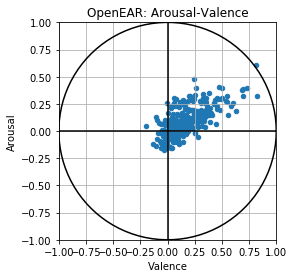

In [3]:
#Now plot Arousal-Valence data in arousal valence space
    
ax_ar_val = df_ar_val.plot.scatter(x = 'Valence', y = 'Arousal')

#We want to plot the arousal valence circle so we create values for it
t = np.linspace(0,np.pi*2,100)
ax_ar_val.plot(np.cos(t), np.sin(t), linewidth = 1.5, color = 'black')
ax_ar_val.axvline(0,0,1, c = 'black')
plt.title('OpenEAR: Arousal-Valence')
x_coord = [-1.0,1.0]
y_coord = [0.0,0.0]
ax_ar_val.plot(x_coord, y_coord, c = 'black')

#Make Plot pretty
#ax_ar_val.legend(loc = 'center', bbox_to_anchor=(1.2,0.5))
plt.grid(True)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
ax_ar_val.set_aspect('equal')
plt.locator_params(axis='x',nbins= 9)

## Let's load information about the speakers
The speaker ID is saved in a single .csv file containing four important columns: ID, Age, Sex and Acadedmic Status. Since before loaded OpenSMILE csv files are named using the corresponding index (ex. speaker with id 0 has two files 0_a.csv and 0_b.csv), so that a link can be created

In [4]:
char_data = pd.read_csv("UIST2019_CharacterData.csv")  

#Join above tables and Character Tables

#To Join DataFrames we have to cast the column on which we want to join to int, so that both columns have the same data type
char_data['ID'] = char_data['ID'].astype(int)
df_ar_val['Char_ID'] = df_ar_val['Char_ID'].astype(int)
df_emotion['Char_ID'] = df_emotion['Char_ID'].astype(int)
df_affect['Char_ID'] = df_affect['Char_ID'].astype(int)
df_loi['Char_ID'] = df_loi['Char_ID'].astype(int)

#Safe new data frames
df_ar_val_char = df_ar_val.merge(char_data, how = 'left', left_on='Char_ID', right_on='ID')
df_emotion_char = df_emotion.merge(char_data, how = 'left', left_on='Char_ID', right_on= 'ID')
df_affect_char = df_affect.merge(char_data, how = 'left', left_on='Char_ID', right_on= 'ID')
df_loi_char = df_loi.merge(char_data, how = 'left', left_on='Char_ID', right_on= 'ID')

## Now let's have another look at the plots using the character data
### Let's take a look at female/male

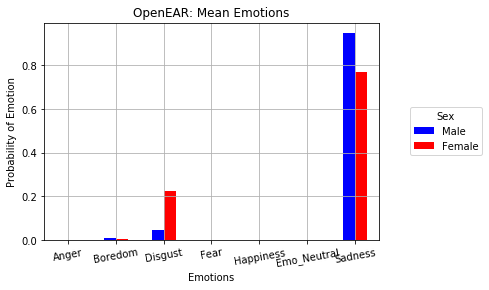

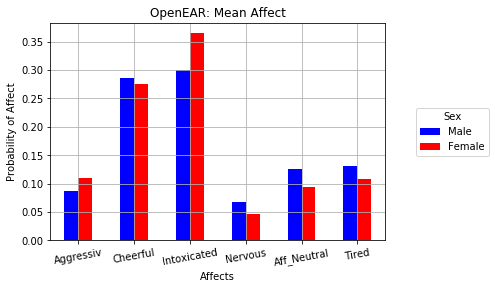

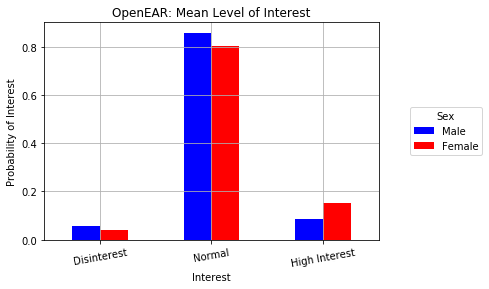

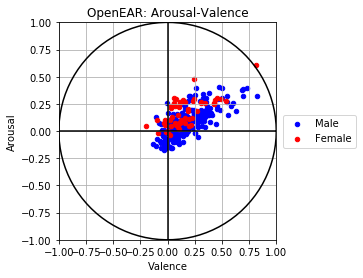

In [5]:
df_ar_val_male = df_ar_val_char.loc[df_ar_val_char['Sex'] == 'Male']
df_ar_val_female = df_ar_val_char.loc[df_ar_val_char['Sex'] == 'Female']

df_emotion_char_male = df_emotion_char.loc[df_emotion_char['Sex'] == 'Male']
df_emotion_char_female = df_emotion_char.loc[df_emotion_char['Sex'] == 'Female']

df_affect_char_male = df_affect_char.loc[df_affect_char['Sex'] == 'Male']
df_affect_char_female = df_affect_char.loc[df_affect_char['Sex'] == 'Female']

df_loi_char_male = df_loi_char.loc[df_loi_char['Sex'] == 'Male']
df_loi_char_female = df_loi_char.loc[df_loi_char['Sex'] == 'Female']

#For Plotting, lets calculate the mean emotion value for all audiofiles
df_emo_sex = hp.createMeanDataFrame([df_emotion_char_male, df_emotion_char_female],'Sex',emotion_label)
df_aff_sex = hp.createMeanDataFrame([df_affect_char_male, df_affect_char_female],'Sex',affect_label)
df_loi_sex = hp.createMeanDataFrame([df_loi_char_male, df_loi_char_female],'Sex',loi_label)

# Start with Emotion
ax_emo = df_emo_sex.plot.bar(title = 'OpenEAR: Mean Emotions',rot = 10, color = ['b','r']) #We set rotation to 10 so that the filenames can be read
ax_emo.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Sex')
ax_emo.set_ylabel('Probability of Emotion')
ax_emo.set_xlabel('Emotions')
plt.grid(True)

#Now let's plot affect bar diagram
ax_aff = df_aff_sex.plot.bar(title = 'OpenEAR: Mean Affect',rot = 10, color = ['b','r']) #We set rotation to 10 so that the filenames can be read
ax_aff.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Sex')
ax_aff.set_ylabel('Probability of Affect')
ax_aff.set_xlabel('Affects')
plt.grid(True)

#Now Level of Interest
ax_loi = df_loi_sex.plot.bar(title = 'OpenEAR: Mean Level of Interest',rot = 10, color = ['b','r']) #We set rotation to 10 so that the filenames can be read
ax_loi.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Sex')
ax_loi.set_ylabel('Probability of Interest')
ax_loi.set_xlabel('Interest')
plt.grid(True)

#And finally arousal valence
ax1 = df_ar_val_male.plot.scatter(x = 'Valence', y = 'Arousal', label = 'Male', c = 'b')
ax2 = df_ar_val_female.plot.scatter(x = 'Valence', y = 'Arousal', label = 'Female', c = 'r', ax=ax1)
#We want to plot the arousal valence circle so we create values for it
t = np.linspace(0,np.pi*2,100)
ax1.plot(np.cos(t), np.sin(t), linewidth = 1.5, color = 'black')
ax1.axvline(0,0,1, c = 'black')
x_coord = [-1.0,1.0]
y_coord = [0.0,0.0]
ax1.plot(x_coord, y_coord, c = 'black')

#Make Plot pretty
ax1.legend(loc = 'center', bbox_to_anchor=(1.2,0.5))
plt.grid(True)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.title('OpenEAR: Arousal-Valence')
ax1.set_aspect('equal')
plt.locator_params(axis='x',nbins= 9)

### Let's have look at academic status
Bachelor and Master will be replaced with the to the video corresponding academic status

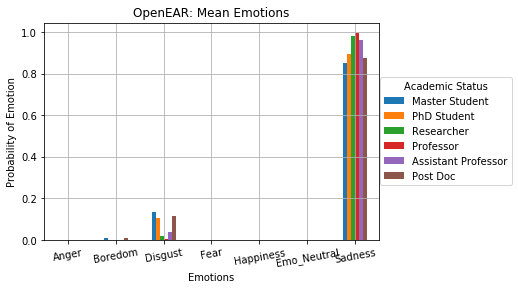

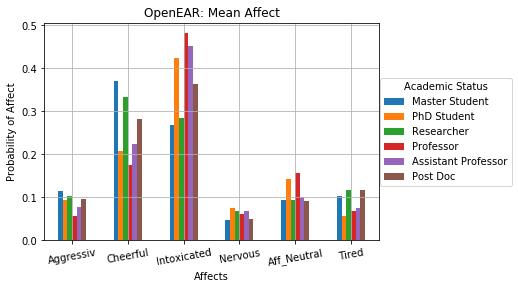

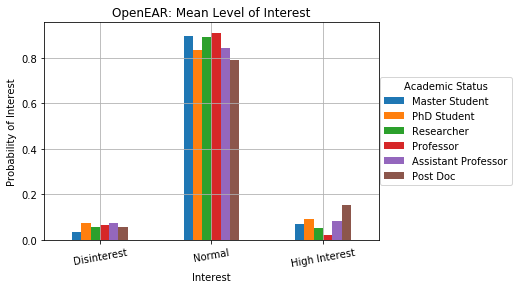

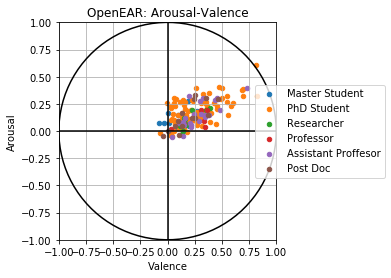

In [6]:
df_ar_val_master = df_ar_val_char.loc[df_ar_val_char['Academic Status'] == 'Master Student']
df_ar_val_phd = df_ar_val_char.loc[df_ar_val_char['Academic Status'] == 'PhD Student']
df_ar_val_research = df_ar_val_char.loc[df_ar_val_char['Academic Status'] == 'Researcher']
df_ar_val_prof = df_ar_val_char.loc[df_ar_val_char['Academic Status'] == 'Professor']
df_ar_val_ass_prof = df_ar_val_char.loc[df_ar_val_char['Academic Status'] == 'Assistant Professor']
df_ar_val_postdoc = df_ar_val_char.loc[df_ar_val_char['Academic Status'] == 'Post Doc']

df_affect_master = df_affect_char.loc[df_affect_char['Academic Status'] == 'Master Student']
df_affect_phd = df_affect_char.loc[df_affect_char['Academic Status'] == 'PhD Student']
df_affect_research = df_affect_char.loc[df_affect_char['Academic Status'] == 'Researcher']
df_affect_prof = df_affect_char.loc[df_affect_char['Academic Status'] == 'Professor']
df_affect_ass_prof = df_affect_char.loc[df_affect_char['Academic Status'] == 'Assistant Professor']
df_affect_postdoc = df_affect_char.loc[df_affect_char['Academic Status'] == 'Post Doc']

df_emotion_master = df_emotion_char.loc[df_emotion_char['Academic Status'] == 'Master Student']
df_emotion_phd = df_emotion_char.loc[df_emotion_char['Academic Status'] == 'PhD Student']
df_emotion_research = df_emotion_char.loc[df_emotion_char['Academic Status'] == 'Researcher']
df_emotion_prof = df_emotion_char.loc[df_emotion_char['Academic Status'] == 'Professor']
df_emotion_ass_prof = df_emotion_char.loc[df_emotion_char['Academic Status'] == 'Assistant Professor']
df_emotion_postdoc = df_emotion_char.loc[df_emotion_char['Academic Status'] == 'Post Doc']

df_loi_master = df_loi_char.loc[df_loi_char['Academic Status'] == 'Master Student']
df_loi_phd = df_loi_char.loc[df_loi_char['Academic Status'] == 'PhD Student']
df_loi_research = df_loi_char.loc[df_loi_char['Academic Status'] == 'Researcher']
df_loi_prof = df_loi_char.loc[df_loi_char['Academic Status'] == 'Professor']
df_loi_ass_prof = df_loi_char.loc[df_loi_char['Academic Status'] == 'Assistant Professor']
df_loi_postdoc = df_loi_char.loc[df_loi_char['Academic Status'] == 'Post Doc']

#For Plotting, lets calculate the mean emotion value for all audiofiles
df_emo_aca = hp.createMeanDataFrame([df_emotion_master,df_emotion_phd, df_emotion_research,df_emotion_prof,df_emotion_ass_prof,df_emotion_postdoc], 'Academic', emotion_label)
df_aff_aca = hp.createMeanDataFrame([df_affect_master,df_affect_phd, df_affect_research,df_affect_prof,df_affect_ass_prof,df_affect_postdoc], 'Academic', affect_label)
df_loi_aca = hp.createMeanDataFrame([df_loi_master,df_loi_phd, df_loi_research,df_loi_prof,df_loi_ass_prof,df_loi_postdoc], 'Academic', loi_label)

# Start with Emotion
ax_emo1 = df_emo_aca.plot.bar(title = 'OpenEAR: Mean Emotions',rot = 10) #We set rotation to 10 so that the filenames can be read
ax_emo1.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Academic Status')
ax_emo1.set_ylabel('Probability of Emotion')
ax_emo1.set_xlabel('Emotions')
plt.grid(True)

#Now let's plot affect bar diagram
ax_aff1 = df_aff_aca.plot.bar(title = 'OpenEAR: Mean Affect',rot = 10) #We set rotation to 10 so that the filenames can be read
ax_aff1.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Academic Status')
ax_aff1.set_ylabel('Probability of Affect')
ax_aff1.set_xlabel('Affects')
plt.grid(True)

#Now plot LoI diagram
ax_loi = df_loi_aca.plot.bar(title = 'OpenEAR: Mean Level of Interest',rot = 10) #We set rotation to 10 so that the filenames can be read
ax_loi.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Academic Status')
ax_loi.set_ylabel('Probability of Interest')
ax_loi.set_xlabel('Interest')
plt.grid(True)

ax11 = df_ar_val_master.plot.scatter(x = 'Valence', y = 'Arousal', label = 'Master Student', c = 'tab:blue')
ax21 = df_ar_val_phd.plot.scatter(x = 'Valence', y = 'Arousal', label = 'PhD Student', c = 'tab:orange', ax=ax11)
ax31 = df_ar_val_research.plot.scatter(x = 'Valence', y = 'Arousal', label = 'Researcher', c = 'tab:green', ax=ax11)
ax41 = df_ar_val_prof.plot.scatter(x = 'Valence', y = 'Arousal', label = 'Professor', c = 'tab:red', ax=ax11)
ax51 = df_ar_val_ass_prof.plot.scatter(x = 'Valence', y = 'Arousal', label = 'Assistant Proffesor', c = 'tab:purple', ax=ax11)
ax61 = df_ar_val_postdoc.plot.scatter(x = 'Valence', y = 'Arousal', label = 'Post Doc', c = 'tab:brown', ax=ax11)
#We want to plot the arousal valence circle so we create values for it
t = np.linspace(0,np.pi*2,100)
ax11.plot(np.cos(t), np.sin(t), linewidth = 1.5, color = 'black')
ax11.axvline(0,0,1, c = 'black')
x_coord = [-1.0,1.0]
y_coord = [0.0,0.0]
ax11.plot(x_coord, y_coord, c = 'black')

#Make Plot pretty
ax11.legend(loc = 'center', bbox_to_anchor=(1.2,0.5))
plt.grid(True)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.title('OpenEAR: Arousal-Valence')
ax11.set_aspect('equal')
plt.locator_params(axis='x',nbins= 9)

### Lastly take a look at age

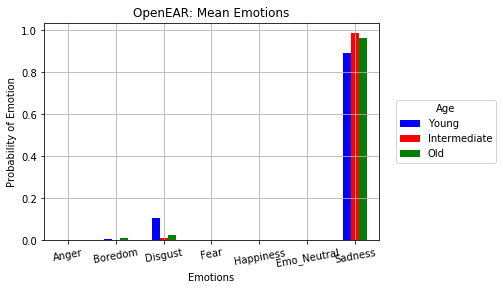

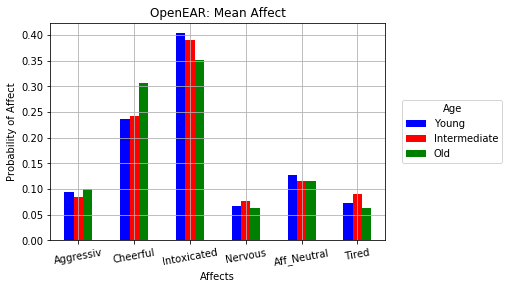

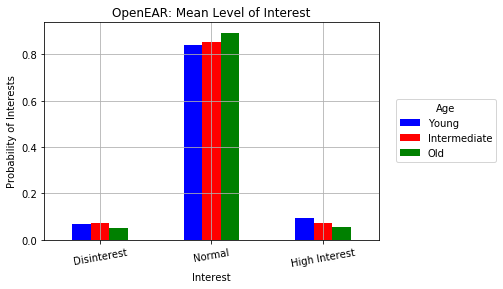

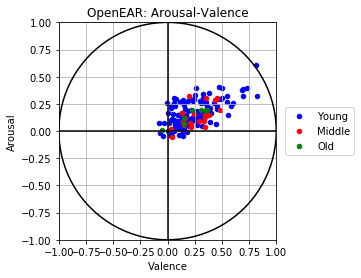

In [7]:
df_ar_val_young = df_ar_val_char.loc[df_ar_val_char['Age'] == 'Young']
df_ar_val_middle = df_ar_val_char.loc[df_ar_val_char['Age'] == 'Intermediate']
df_ar_val_old = df_ar_val_char.loc[df_ar_val_char['Age'] == 'Old']

df_emotion_young= df_emotion_char.loc[df_emotion_char['Age'] == 'Young']
df_emotion_middle = df_emotion_char.loc[df_emotion_char['Age'] == 'Intermediate']
df_emotion_old = df_emotion_char.loc[df_emotion_char['Age'] == 'Old']

df_affect_young = df_affect_char.loc[df_affect_char['Age'] == 'Young']
df_affect_middle = df_affect_char.loc[df_affect_char['Age'] == 'Intermediate']
df_affect_old = df_affect_char.loc[df_affect_char['Age'] == 'Old']

df_loi_young = df_loi_char.loc[df_loi_char['Age'] == 'Young']
df_loi_middle = df_loi_char.loc[df_loi_char['Age'] == 'Intermediate']
df_loi_old = df_loi_char.loc[df_loi_char['Age'] == 'Old']

#For Plotting, lets calculate the mean emotion value for all audiofiles
df_emo_age = hp.createMeanDataFrame([df_emotion_young, df_emotion_middle,df_emotion_old], 'Age', emotion_label)
df_aff_age = hp.createMeanDataFrame([df_affect_young, df_affect_middle,df_affect_old], 'Age', affect_label)
df_loi_age = hp.createMeanDataFrame([df_loi_young, df_loi_middle,df_loi_old], 'Age', loi_label)



# Start Plotting Emotion
ax_emo2 = df_emo_age.plot.bar(title = 'OpenEAR: Mean Emotions',rot = 10, color = ['b','r', 'g']) #We set rotation to 10 so that the filenames can be read
ax_emo2.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Age')
ax_emo2.set_ylabel('Probability of Emotion')
ax_emo2.set_xlabel('Emotions')
plt.grid(True)

#Now let's plot affect bar diagram
ax_aff2 = df_aff_age.plot.bar(title = 'OpenEAR: Mean Affect',rot = 10, color = ['b','r', 'g']) #We set rotation to 10 so that the filenames can be read
ax_aff2.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Age')
ax_aff2.set_ylabel('Probability of Affect')
ax_aff2.set_xlabel('Affects')
plt.grid(True)

#And Level of Interest
ax_loi = df_loi_age.plot.bar(title = 'OpenEAR: Mean Level of Interest',rot = 10, color = ['b','r', 'g']) #We set rotation to 10 so that the filenames can be read
ax_loi.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Age')
ax_loi.set_ylabel('Probability of Interests')
ax_loi.set_xlabel('Interest')
plt.grid(True)

ax200 = df_ar_val_young.plot.scatter(x = 'Valence', y = 'Arousal', label = 'Young', c = 'b')
ax201 = df_ar_val_middle.plot.scatter(x = 'Valence', y = 'Arousal', label = 'Middle', c = 'r', ax=ax200)
ax202 = df_ar_val_old.plot.scatter(x = 'Valence', y = 'Arousal', label = 'Old', c = 'g', ax=ax200)
#We want to plot the arousal valence circle so we create values for it
t = np.linspace(0,np.pi*2,100)
ax200.plot(np.cos(t), np.sin(t), linewidth = 1.5, color = 'black')
ax200.axvline(0,0,1, c = 'black')
x_coord = [-1.0,1.0]
y_coord = [0.0,0.0]
ax200.plot(x_coord, y_coord, c = 'black')

#Make Plot pretty
ax200.legend(loc = 'center', bbox_to_anchor=(1.2,0.5))
plt.grid(True)
plt.title('OpenEAR: Arousal-Valence')
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
ax200.set_aspect('equal')
plt.locator_params(axis='x',nbins= 9)

## Distribution Plots
We want to take a look at the distribution of our emotions, affects, level of interest and arousal-valence. So, every emotion, e.g. anger is plotted using seaborns kdeplot().

For Arousal-Valence, we'll use jointplot(kind = "kde")

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0.98,'Distribution of Arousal and Valence')

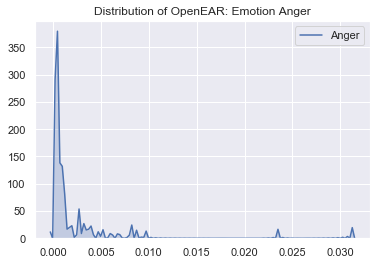

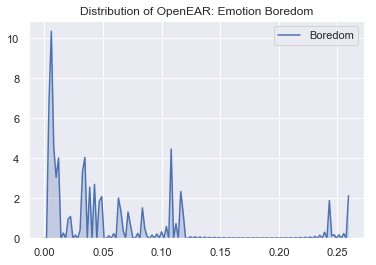

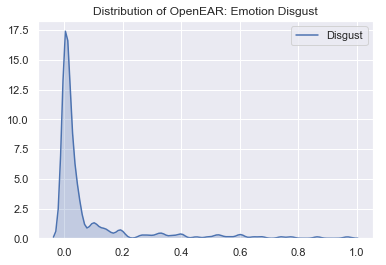

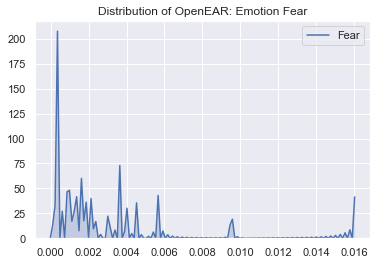

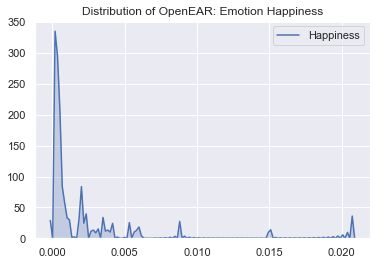

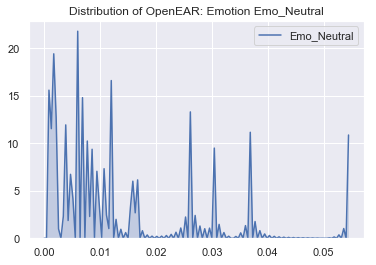

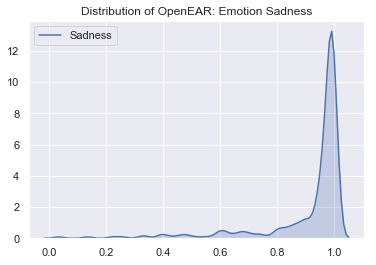

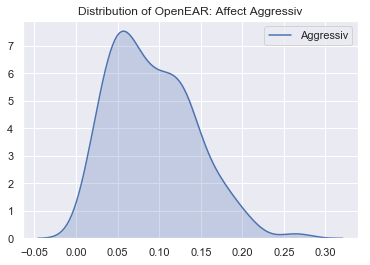

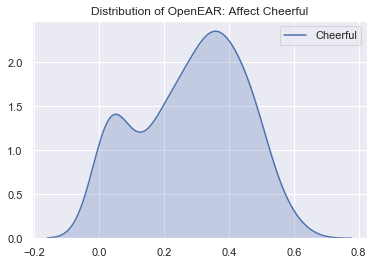

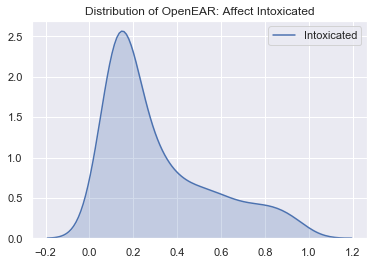

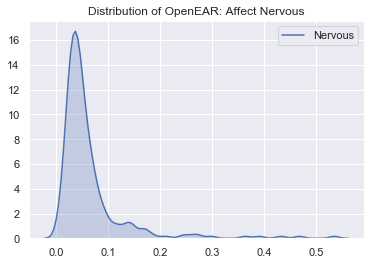

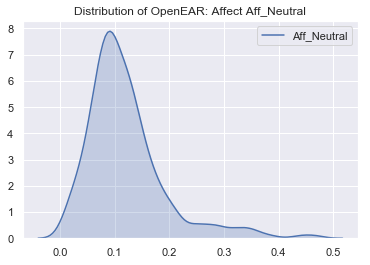

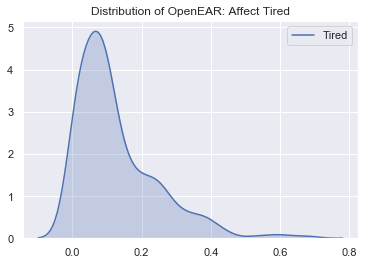

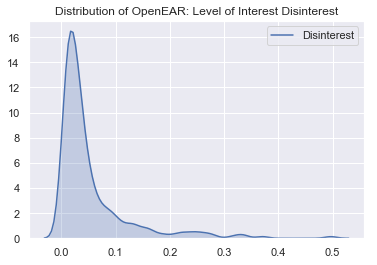

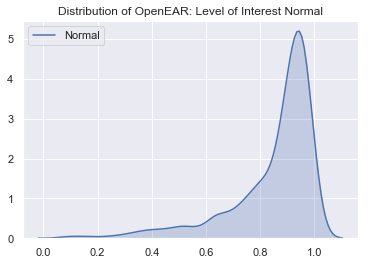

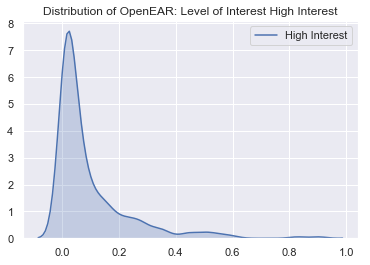

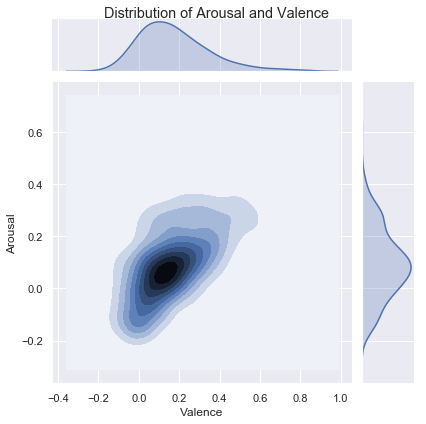

In [8]:
sns.set()
hp.distPlots(df_emotion, emotion_label, 0)
hp.distPlots(df_affect, affect_label, 1)
hp.distPlots(df_loi, loi_label, 2)
df_dis_ar_val_sex = df_ar_val_char.drop(['Char_ID','ID','Filename', 'Age', 'Sex', 'Academic Status', 'VideoTitle', 'Name'], axis = 1)
grid = sns.jointplot(x = "Valence", y = "Arousal", data = df_ar_val, kind = "kde")
ax = grid.ax_joint
grid.fig.subplots_adjust(top = 0.95)
grid.fig.suptitle('Distribution of Arousal and Valence')

## Swarm Plots of categorical data in relation to characteristic features
### Starting with Sex

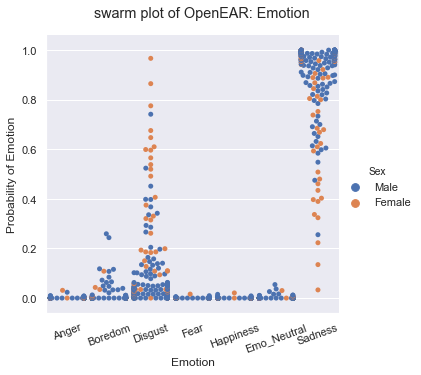

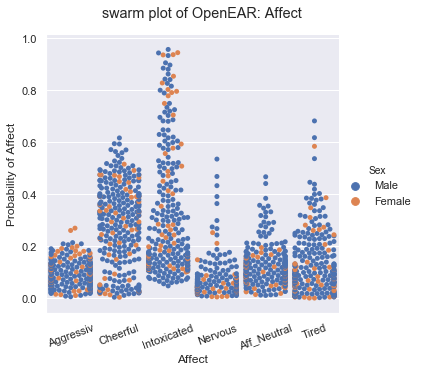

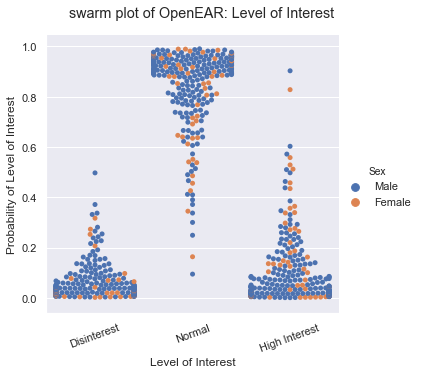

In [9]:
#Start plotting distribution of categorical data with seaborn
#e.g. emotions and sex

df_dis_emotion_sex = df_emotion_char.drop(['Char_ID','ID','Filename', 'Age', 'Academic Status', 'VideoTitle', 'Name'], axis = 1)
df_dis_affect_sex = df_affect_char.drop(['Char_ID','ID','Filename', 'Age', 'Academic Status', 'VideoTitle', 'Name'], axis = 1)
df_dis_loi_sex = df_loi_char.drop(['Char_ID','ID','Filename', 'Age',  'Academic Status', 'VideoTitle', 'Name'], axis = 1)

hp.catPlot(df_dis_emotion_sex, 'Emotion', 'Sex', 'swarm')
plt.xticks(rotation=20)

hp.catPlot(df_dis_affect_sex, 'Affect', 'Sex', 'swarm')
plt.xticks(rotation=20)

hp.catPlot(df_dis_loi_sex, 'Level of Interest', 'Sex', 'swarm')

### Now Academic Status

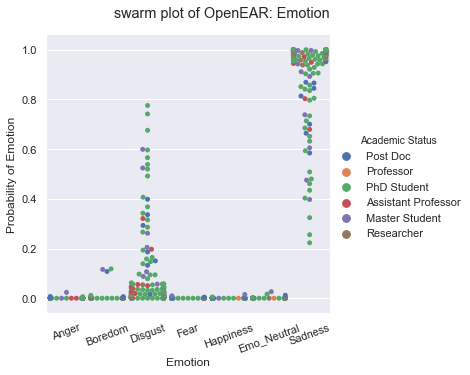

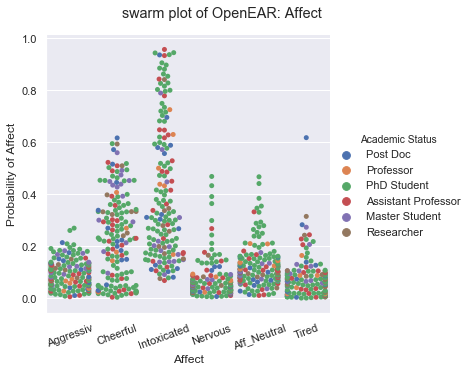

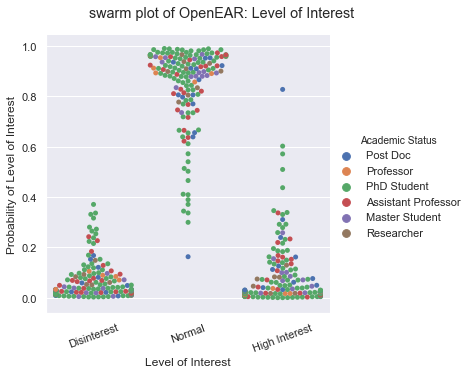

In [10]:
df_dis_emotion_aca = df_emotion_char.drop(['Char_ID','ID','Filename', 'Age', 'Sex', 'VideoTitle', 'Name'], axis = 1)
hp.catPlot(df_dis_emotion_aca, 'Emotion', 'Academic Status', 'swarm')
df_dis_affect_aca = df_affect_char.drop(['Char_ID','ID','Filename', 'Age', 'Sex', 'VideoTitle', 'Name'], axis = 1)
hp.catPlot(df_dis_affect_aca, 'Affect', 'Academic Status', 'swarm')
df_dis_loi_aca = df_loi_char.drop(['Char_ID','ID','Filename', 'Age', 'Sex', 'VideoTitle', 'Name'], axis = 1)
hp.catPlot(df_dis_loi_aca, 'Level of Interest', 'Academic Status', 'swarm')

### Now Age

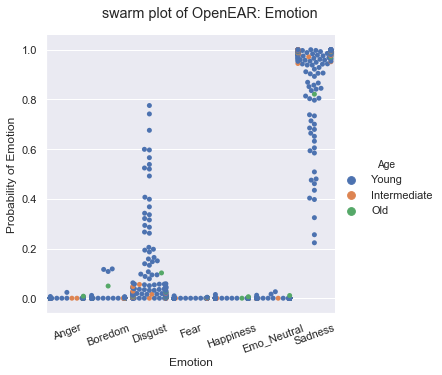

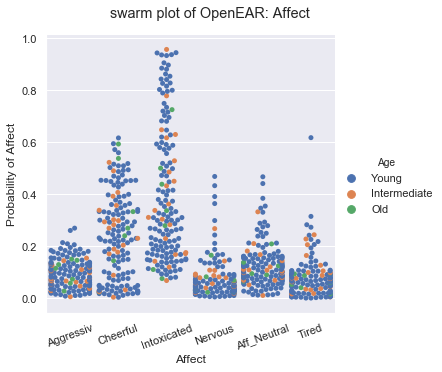

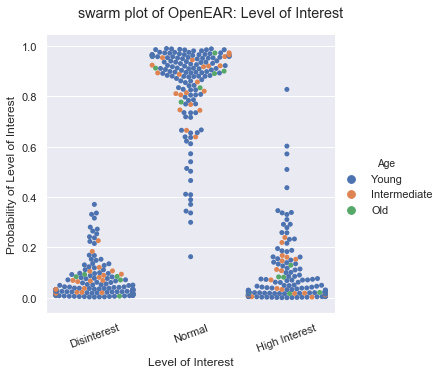

In [11]:
df_dis_emotion_age = df_emotion_char.drop(['Char_ID','ID','Filename', 'Sex', 'Academic Status', 'VideoTitle', 'Name'], axis = 1)
hp.catPlot(df_dis_emotion_age, 'Emotion', 'Age', 'swarm')
df_dis_affect_age = df_affect_char.drop(['Char_ID','ID','Filename', 'Sex', 'Academic Status', 'VideoTitle', 'Name'], axis = 1)
hp.catPlot(df_dis_affect_age, 'Affect', 'Age', 'swarm')
df_dis_loi_age = df_loi_char.drop(['Char_ID','ID','Filename', 'Sex', 'Academic Status', 'VideoTitle', 'Name'], axis = 1)
hp.catPlot(df_dis_loi_age, 'Level of Interest', 'Age', 'swarm')

## Pairplots
### Starting with Emotions and Sex

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1.02,'Pairplot of OpenEAR: Emotions using hue = sex')

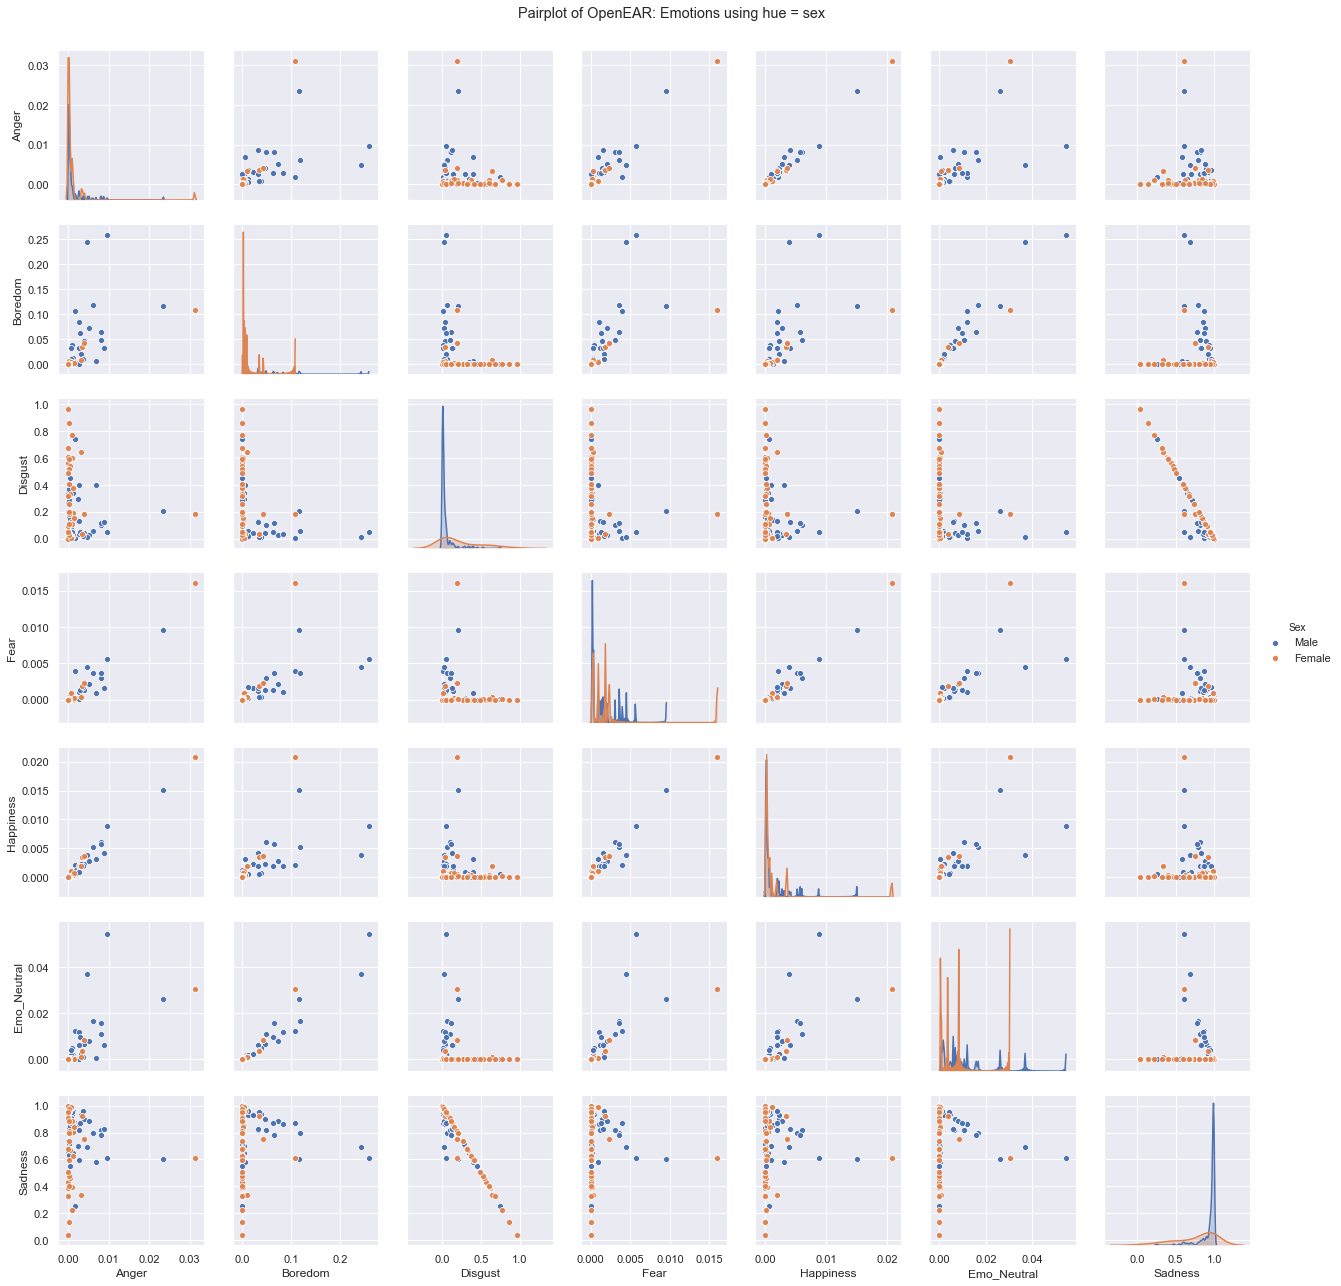

In [12]:
g = sns.pairplot(df_dis_emotion_sex, hue = "Sex")
#plt.subplots_adjust(top = 1.0)
g.fig.suptitle('Pairplot of OpenEAR: Emotions using hue = sex', y = 1.02)

### Affect and Sex

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1.02,'Pairplot of OpenEAR: Affect using hue = sex')

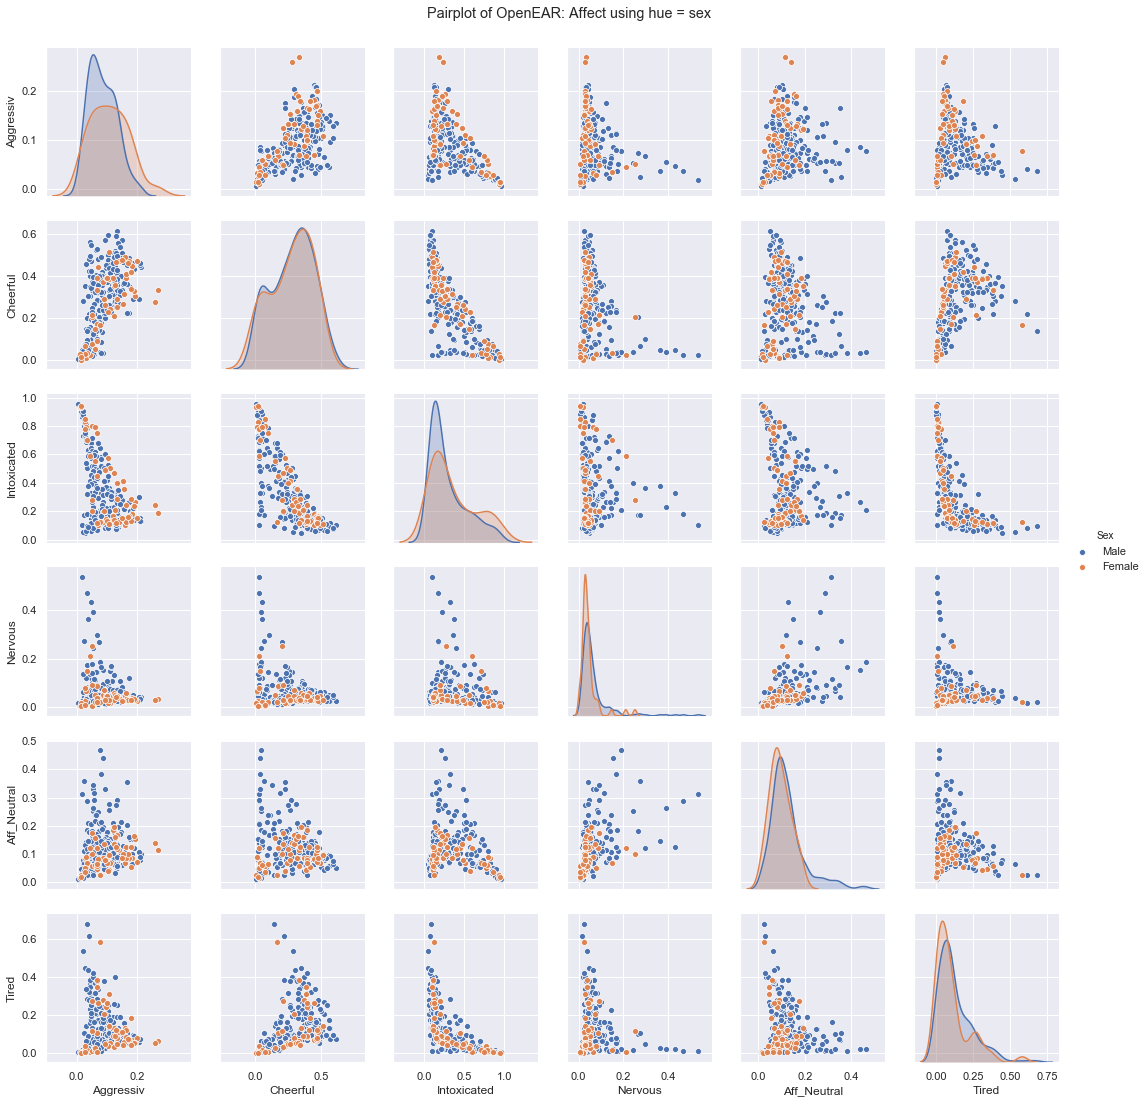

In [13]:
g = sns.pairplot(df_dis_affect_sex, hue = "Sex")
g.fig.suptitle('Pairplot of OpenEAR: Affect using hue = sex', y = 1.02)

### Level of Interest and Sex

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1.02,'Pairplot of OpenEAR: Level of Interest using hue = sex')

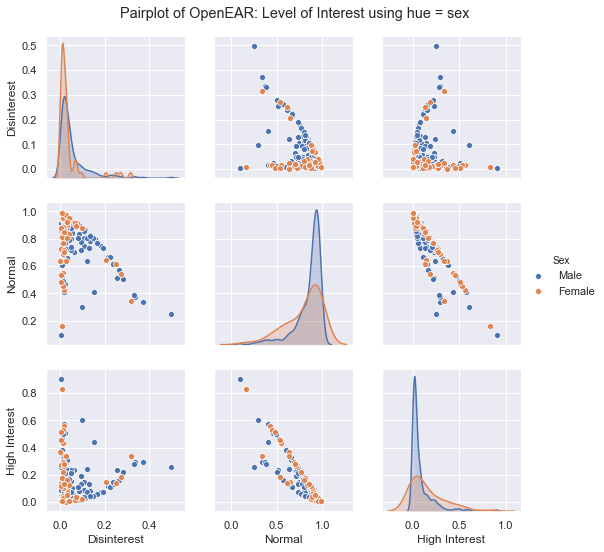

In [14]:
g = sns.pairplot(df_dis_loi_sex, hue = "Sex")
g.fig.suptitle('Pairplot of OpenEAR: Level of Interest using hue = sex', y = 1.02)

### Emotions and Academic Status

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1.02,'Pairplot of OpenEAR: Emotions using hue = Academic Status')

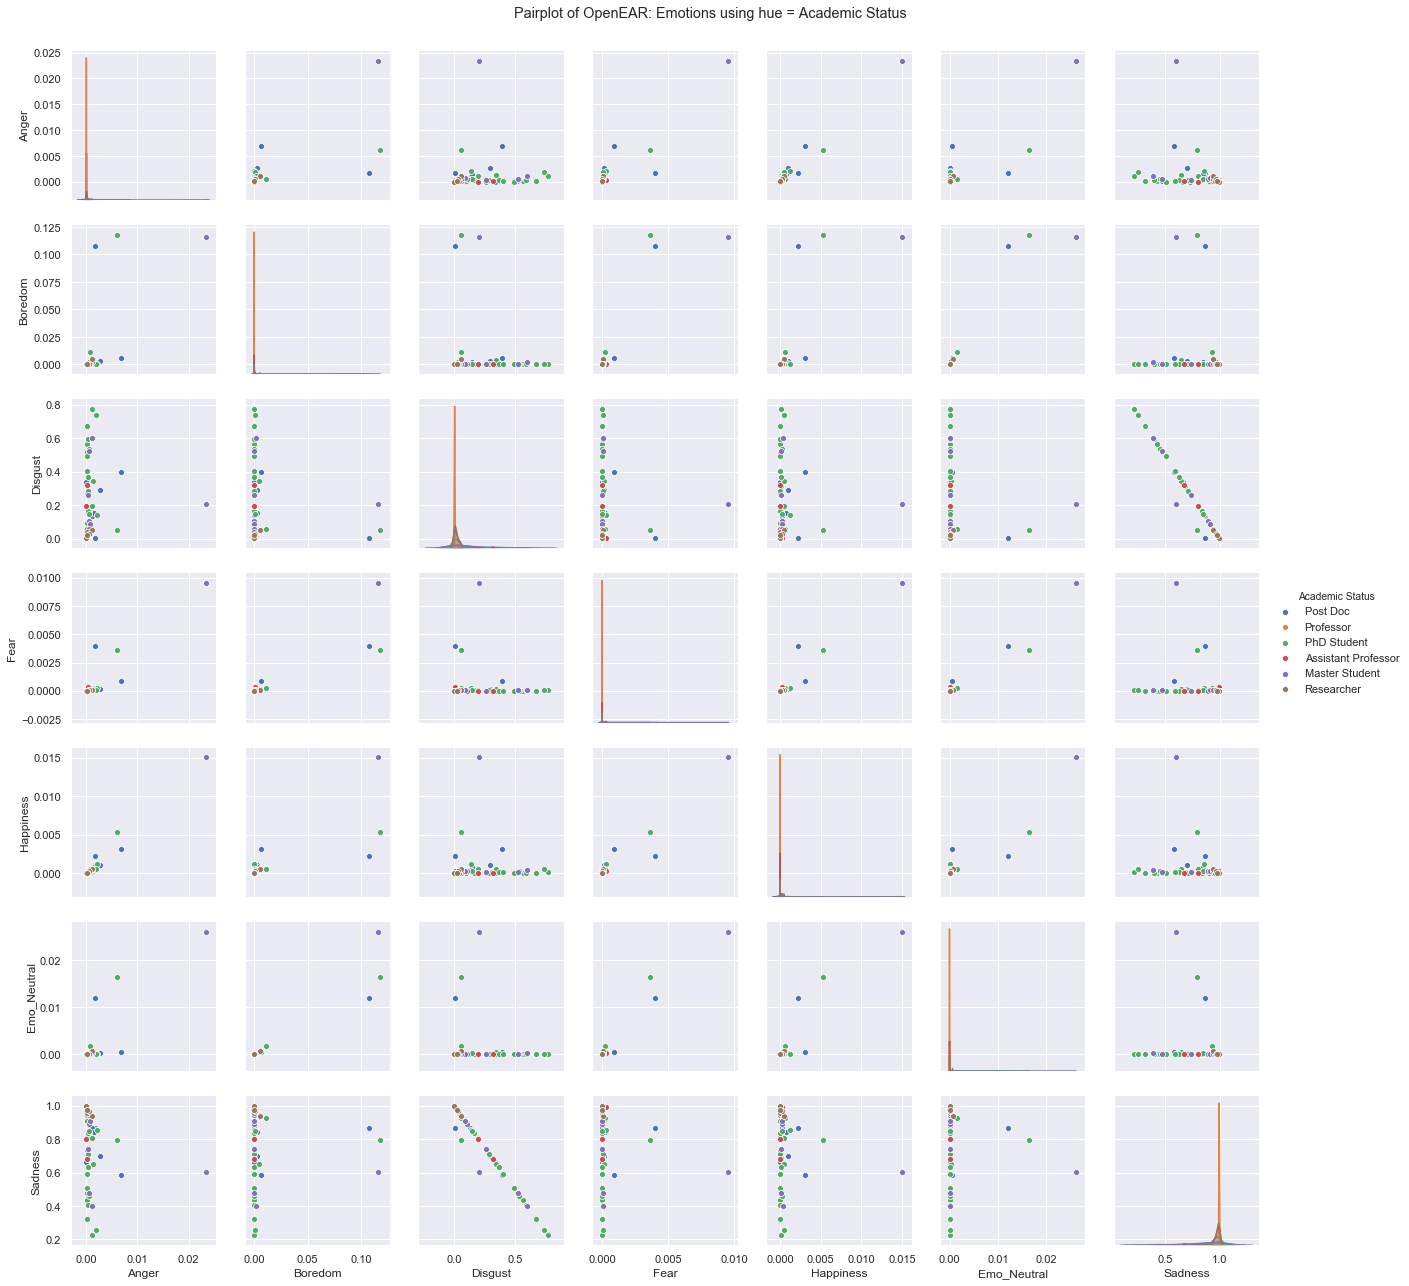

In [15]:
g = sns.pairplot(df_dis_emotion_aca, hue = "Academic Status")
g.fig.suptitle('Pairplot of OpenEAR: Emotions using hue = Academic Status', y = 1.02)

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1.02,'Pairplot of OpenEAR: Affect using hue = Academic Status')

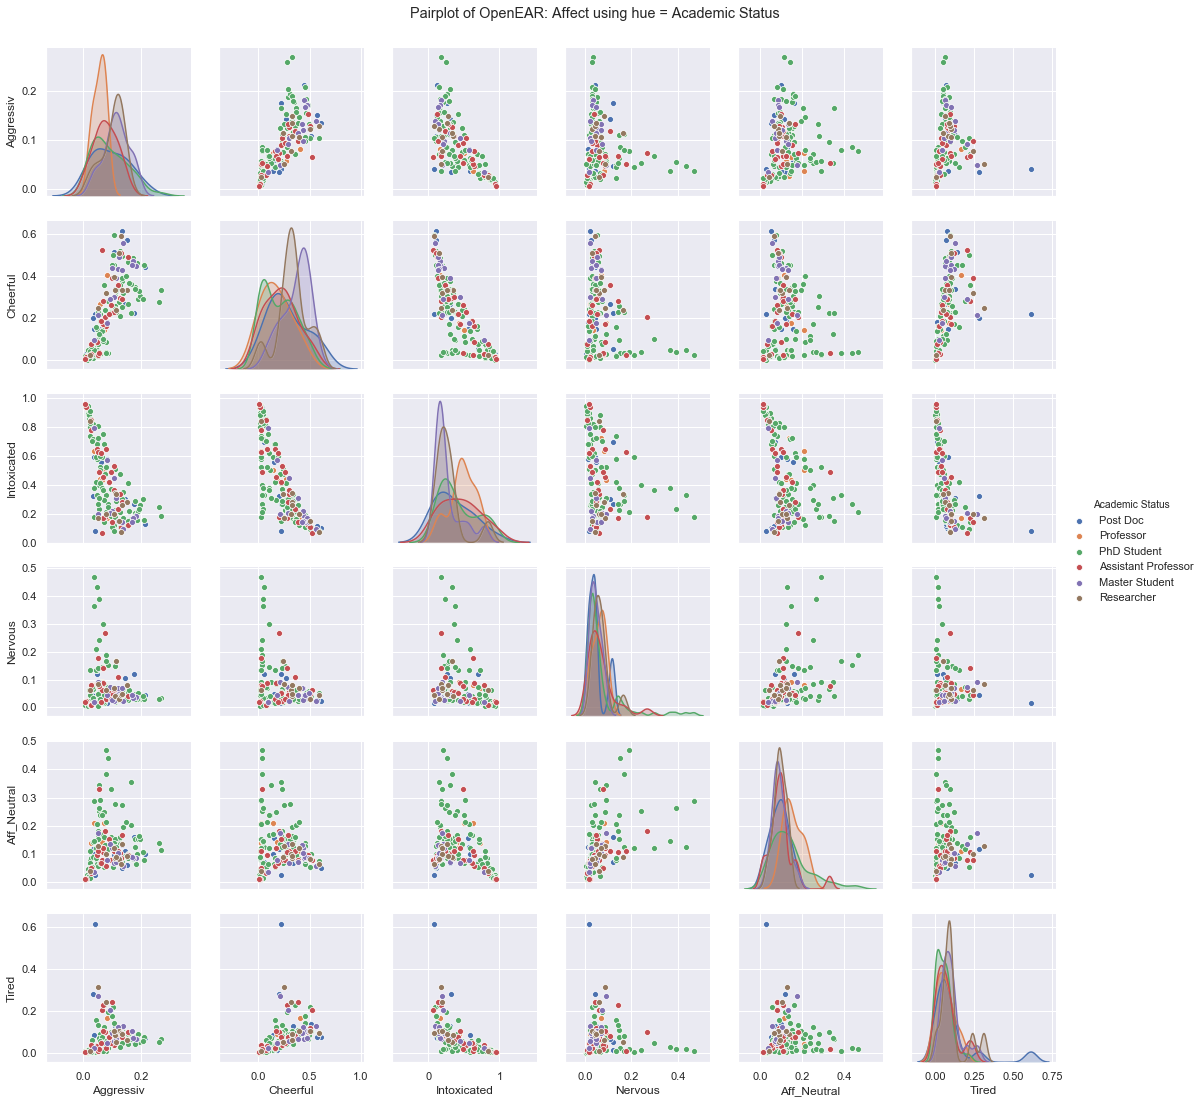

In [16]:
g = sns.pairplot(df_dis_affect_aca, hue = "Academic Status")
g.fig.suptitle('Pairplot of OpenEAR: Affect using hue = Academic Status', y = 1.02)

### Level of Interest and Academic Status

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1.02,'Pairplot of OpenEAR: Level of Interest using hue = Academic Status')

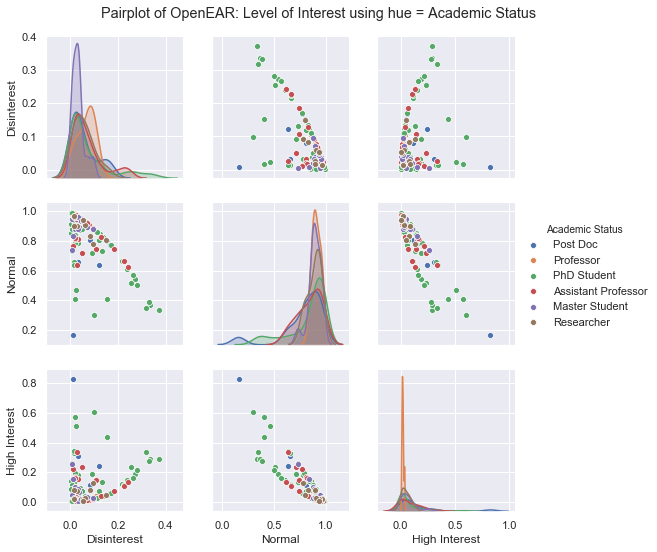

In [17]:
g = sns.pairplot(df_dis_loi_aca, hue = "Academic Status")
g.fig.suptitle('Pairplot of OpenEAR: Level of Interest using hue = Academic Status', y = 1.02)

### Emotion and Age

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1.02,'Pairplot of OpenEAR: Emotions using hue = Age')

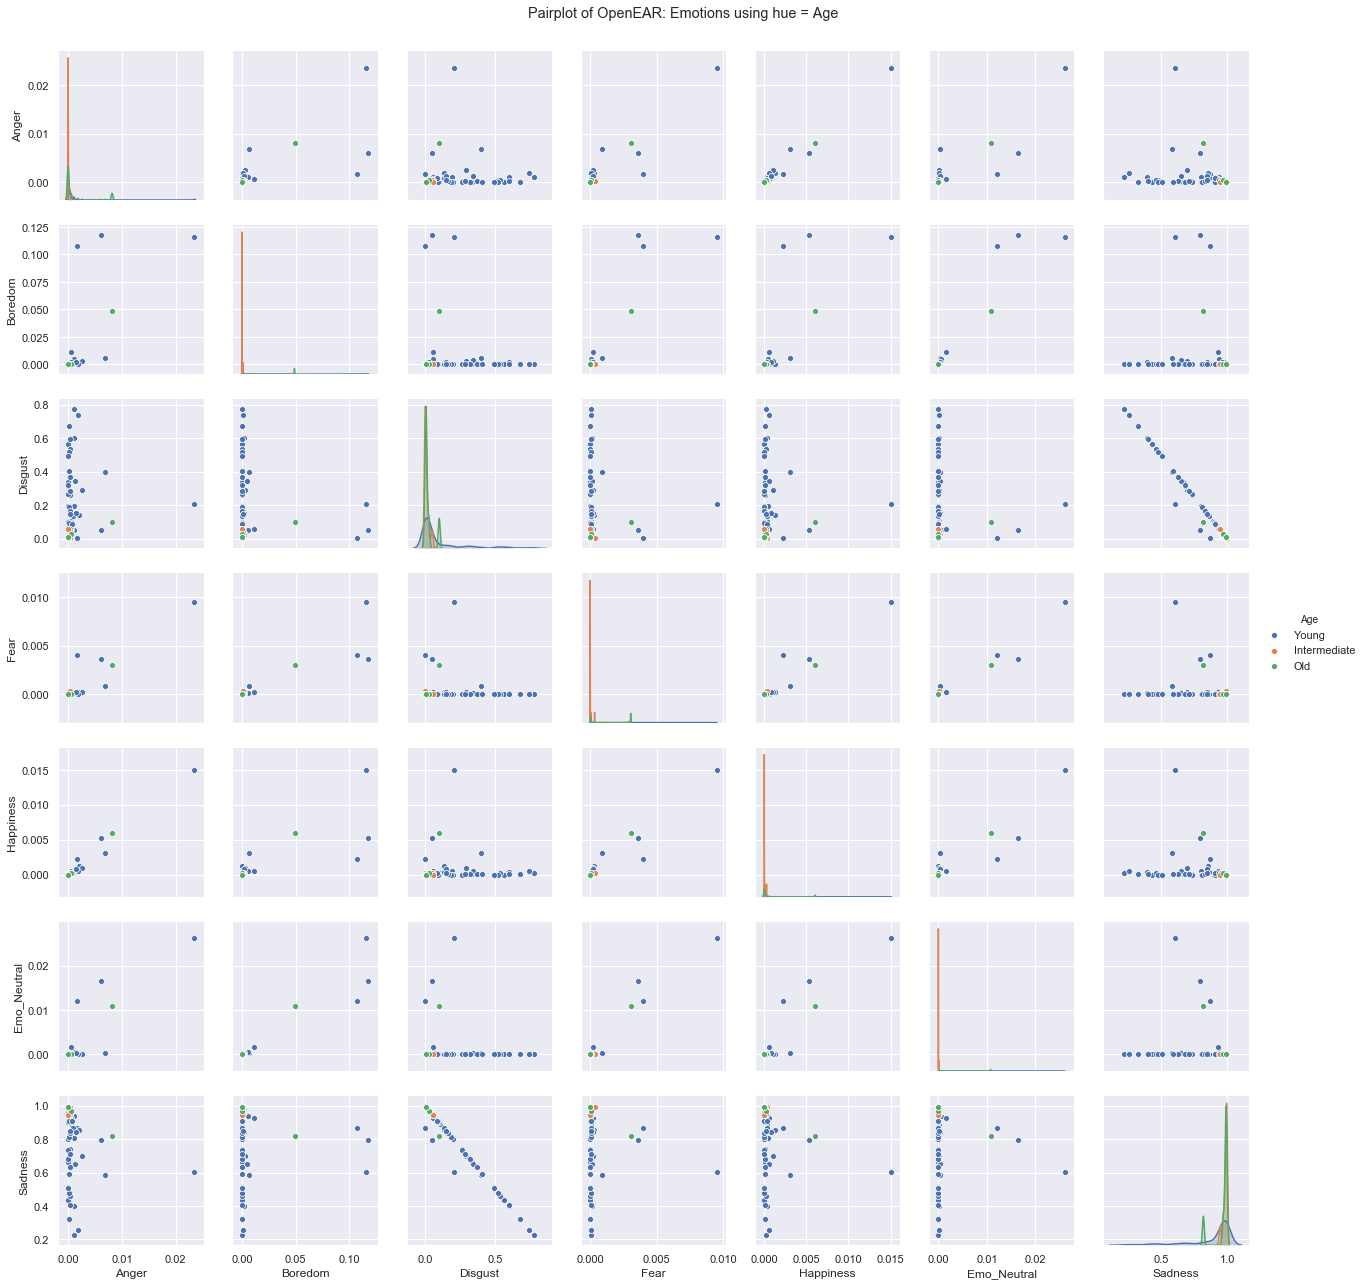

In [18]:
g = sns.pairplot(df_dis_emotion_age, hue = "Age")
g.fig.suptitle('Pairplot of OpenEAR: Emotions using hue = Age', y = 1.02)

### Affect and Age

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1.02,'Pairplot of OpenEAR: Affect using hue = Age')

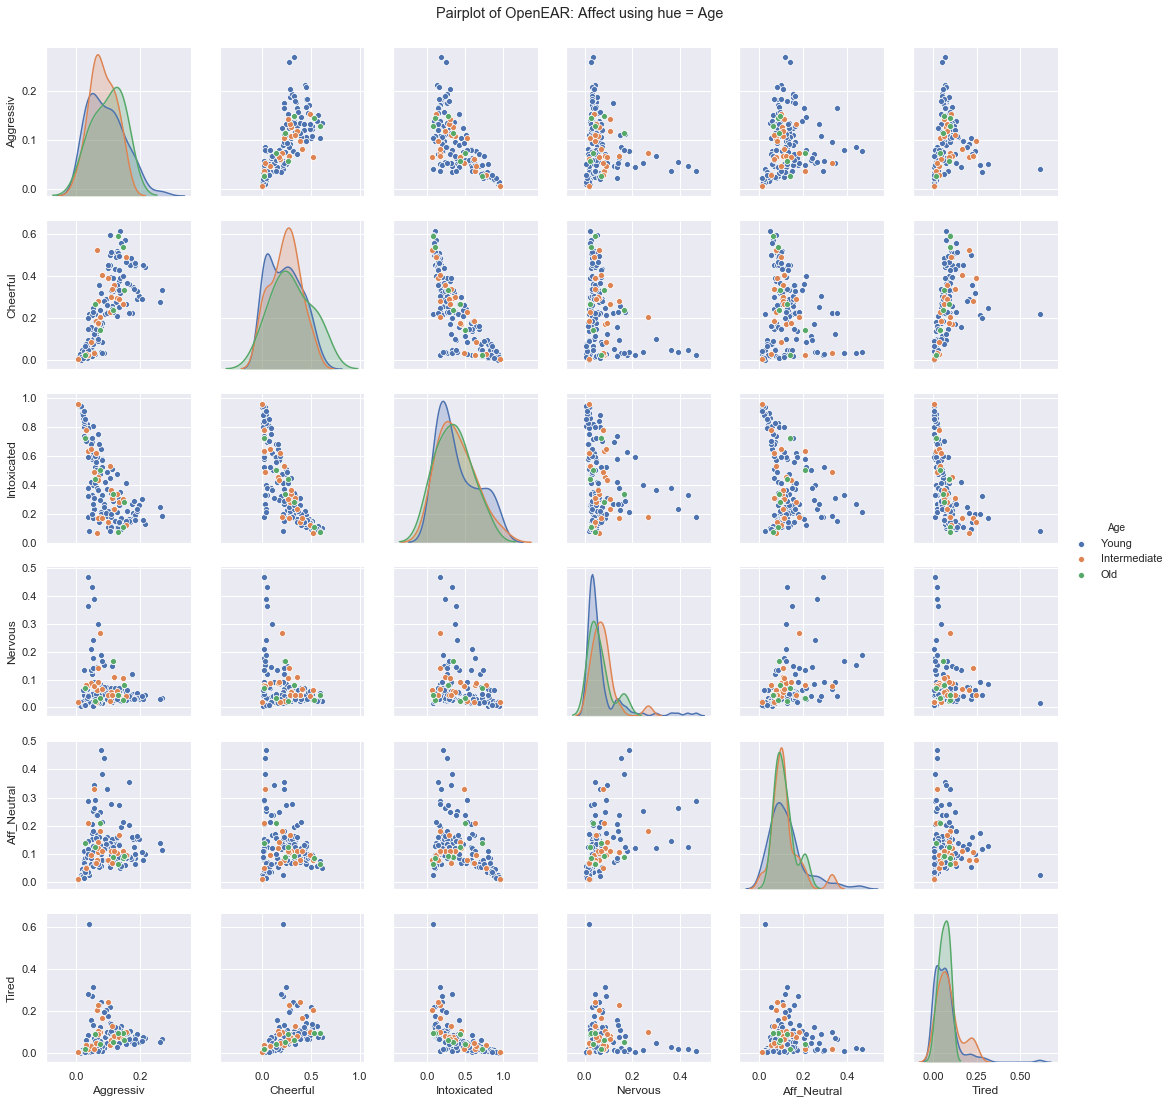

In [19]:
g = sns.pairplot(df_dis_affect_age, hue = "Age")
g.fig.suptitle('Pairplot of OpenEAR: Affect using hue = Age', y = 1.02)

### Level of Interest and Age

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1.02,'Pairplot of OpenEAR: Emotions using hue = Age')

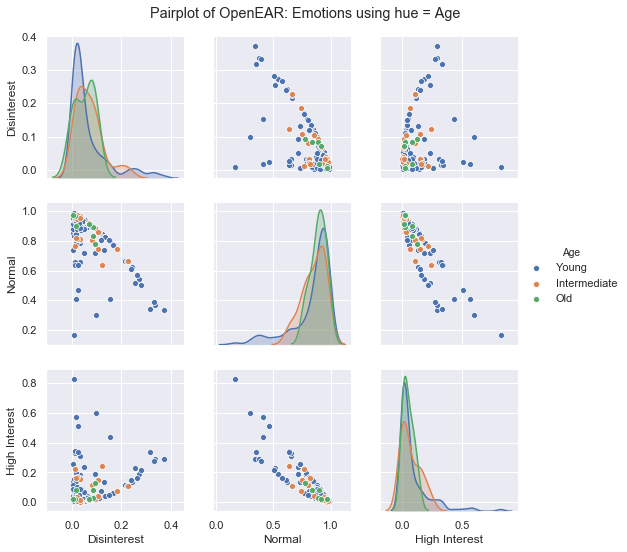

In [20]:
g = sns.pairplot(df_dis_loi_age, hue = "Age")
g.fig.suptitle('Pairplot of OpenEAR: Emotions using hue = Age', y = 1.02)

## Box Plots
### Start with Sex

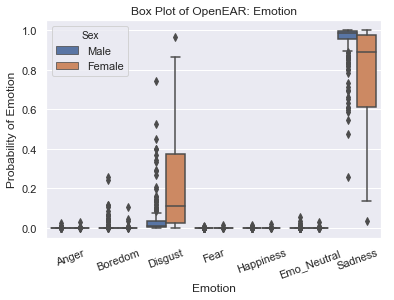

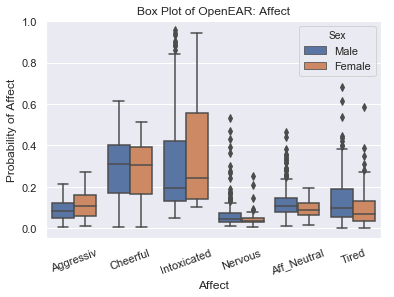

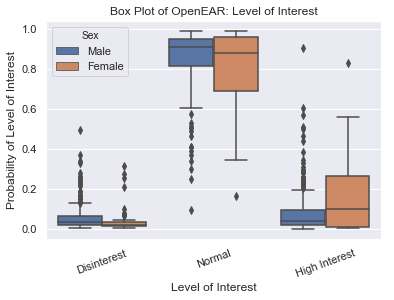

<Figure size 432x288 with 0 Axes>

In [21]:
hp.boxPlots([df_dis_emotion_sex,df_dis_affect_sex, df_dis_loi_sex], 'Sex', ['Emotion', 'Affect', 'Level of Interest'])

### Go on with Academic Status

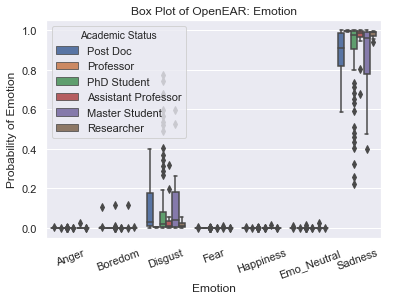

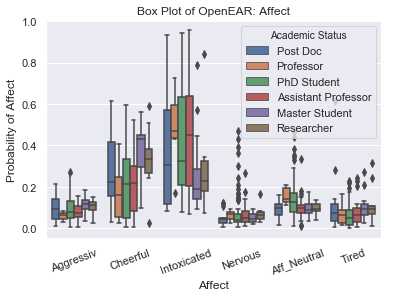

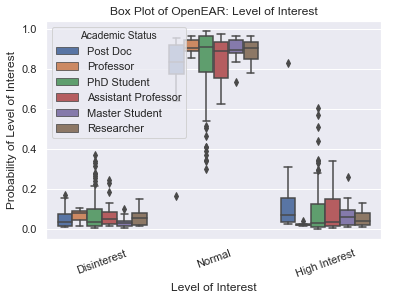

<Figure size 432x288 with 0 Axes>

In [22]:
hp.boxPlots([df_dis_emotion_aca,df_dis_affect_aca, df_dis_loi_aca], 'Academic Status', ['Emotion', 'Affect', 'Level of Interest'])

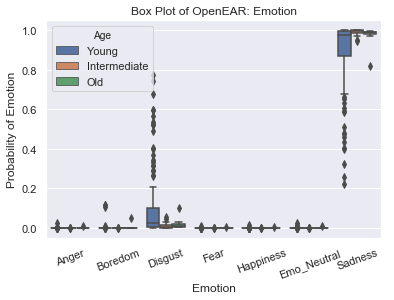

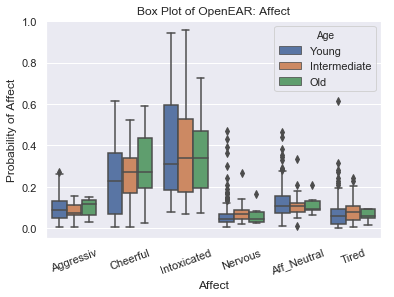

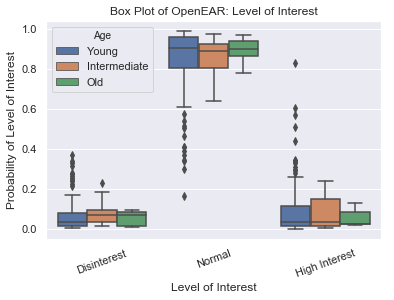

<Figure size 432x288 with 0 Axes>

In [23]:
hp.boxPlots([df_dis_emotion_age,df_dis_affect_age, df_dis_loi_age], 'Age', ['Emotion', 'Affect', 'Level of Interest'])